# Part 1: Feature Extraction
## Permutation Entropy
### 1) Load EEG data

In [2]:
import numpy as np

# Load Patient 14 data from text file
eeg_data = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 EEG.txt')

### 2) Band filter

In [3]:
from scipy.signal import butter, filtfilt

# Define band filter
def band_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Sampling frequency = 128 Hz
fs = 128

# Apply filters for each band
delta_band = band_filter(eeg_data, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band = band_filter(eeg_data, 4, 8, fs) # 4 to 8 Hz
alpha_band = band_filter(eeg_data, 8, 13, fs) # 8 to 13 Hz
beta_band = band_filter(eeg_data, 13, 30, fs) # 13 to 30 Hz
gamma_band = band_filter(eeg_data, 30, 63, fs) # 30 to 63 Hz (within Nyquist range)

### 3) Separate beta band into overlapping windows

In [4]:
# Create overlapping 56 s windows of beta band, advancing by 1 s
def moving_window(data, window_size, step_size, fs):
    num_points = len(data)
    window_length = window_size * fs # Length of window in data points
    step_length = step_size * fs # Length of step in data points
    windows = []
    for start in range(0, num_points - window_length + 1, step_length):
        windows.append(data[start:start + window_length])
    return np.array(windows)

window_size = 56 # Length of window in seconds
step_size = 1 # Length of step in seconds
beta_windows = moving_window(beta_band, window_size, step_size, fs)

In [5]:
print(beta_windows.shape) ## Check window count and number of data points in each

(3001, 7168)


### 4) Calculate permutation entropy of each window

In [6]:
from pyentrp import entropy as ent

pe_values = []
for window in beta_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values.append(pe)

pe_values = np.array(pe_values)

### 5) Plot permutation entropy values

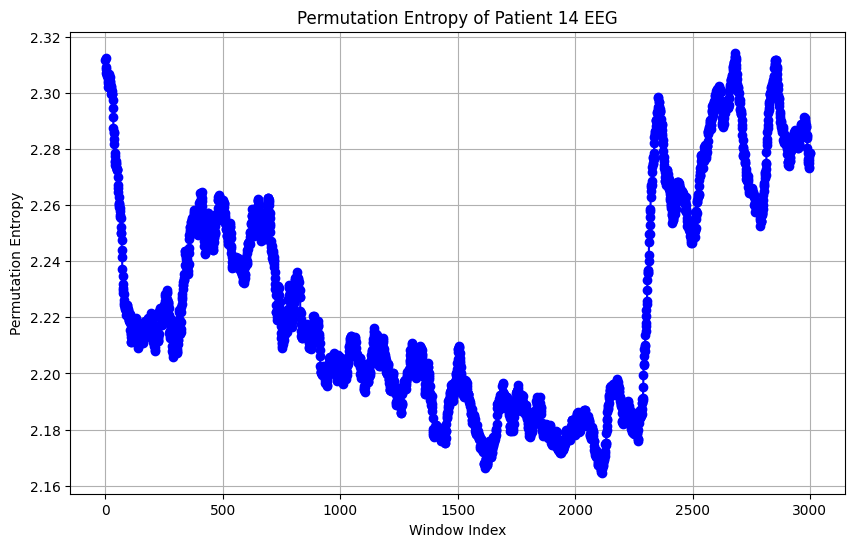

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pe_values, marker='o', linestyle='-', color='b')
plt.title('Permutation Entropy of Patient 14 EEG')
plt.xlabel('Window Index')
plt.ylabel('Permutation Entropy')
plt.grid(True)
plt.show()

## 6) Comparison with Bispectral Index (BIS)

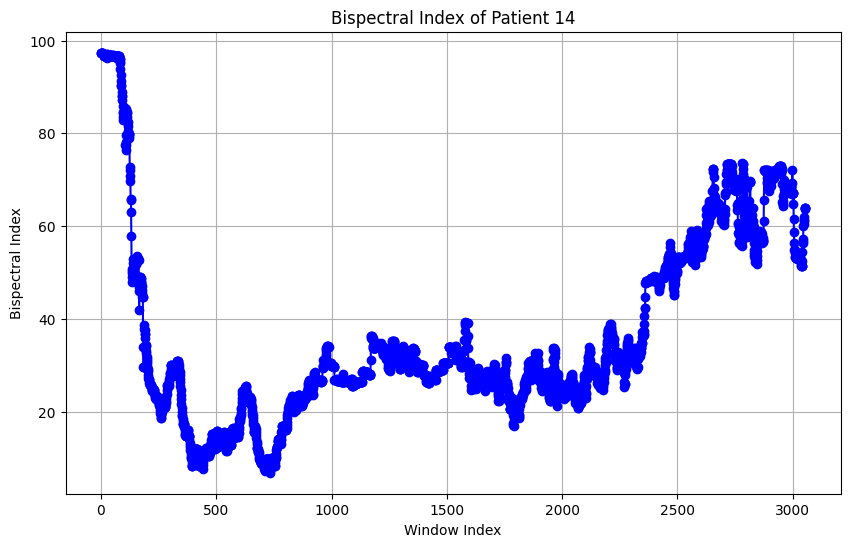

In [8]:
patient14_bis = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 BIS.txt')
plt.figure(figsize=(10, 6))
plt.plot(patient14_bis, marker='o', linestyle='-', color='b')
plt.title('Bispectral Index of Patient 14')
plt.xlabel('Window Index')
plt.ylabel('Bispectral Index')
plt.grid(True)
plt.show()

## Mobility
### 1) Calculate mobility for Patient 14

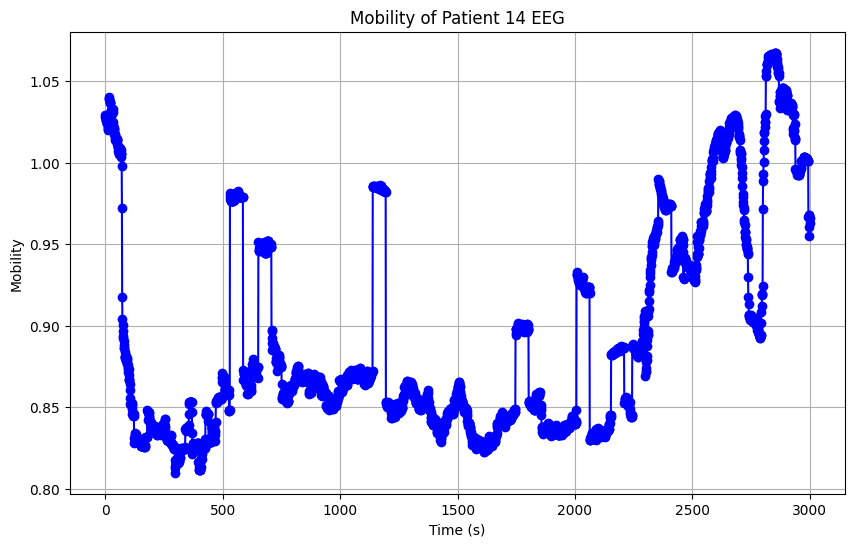

(3001,)


In [9]:
# Calculate mobility of given dataset
def calculate_mobility(signal):
    first_derivative = np.diff(signal, 1)
    variance = np.var(signal)
    variance_first_derivative = np.var(first_derivative)
    mobility = np.sqrt(variance_first_derivative / variance)
    return mobility

# Calculate mobility for each second
mobility_values = []
for window in beta_windows:
    m = calculate_mobility(window)
    mobility_values.append(m)

mobility_values = np.array(mobility_values)

# Plot mobility
plt.figure(figsize=(10, 6))
plt.plot(mobility_values, marker='o', linestyle='-', color='b')
plt.title('Mobility of Patient 14 EEG')
plt.xlabel('Time (s)')
plt.ylabel('Mobility')
plt.grid(True)
plt.show()

print(mobility_values.shape)

**Discussion:**
The above figure graphs the mobility of each second of Patient 14's EEG. The variation is generally consistent across the signal, but there is noticeably lower variation during the first ~100 seconds and heightened variation towards the end. The period of low variation roughly coincides with the consistent drop in permutation entropy and BIS, which must be due to anesthetic being administered during this time.

### 2) Calculate mobility for Patient 12

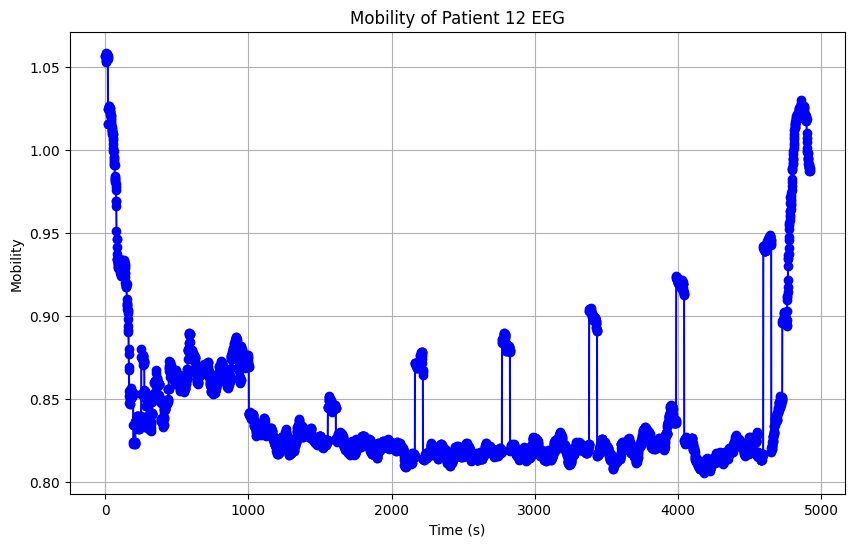

In [10]:
# Load Patient 12 data
eeg_data_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 EEG data.txt')
bis_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 BIS.txt')

# Apply filters for each band for Patient 12
delta_band_patient12 = band_filter(eeg_data_patient12, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band_patient12 = band_filter(eeg_data_patient12, 4, 8, fs) # 4 to 8 Hz
alpha_band_patient12 = band_filter(eeg_data_patient12, 8, 13, fs) # 8 to 13 Hz
beta_band_patient12 = band_filter(eeg_data_patient12, 13, 30, fs) # 13 to 30 Hz
gamma_band_patient12 = band_filter(eeg_data_patient12, 30, 63, fs) # 30 to 63 Hz (within Nyquist range)

# Split beta band into 56 s long moving window (55s overlap)
mobility_windows_patient12 = moving_window(beta_band_patient12, window_size, step_size, fs)

# Calculate mobility for each second
mobility_values_patient12 = []
for window in mobility_windows_patient12:
    m = calculate_mobility(window)
    mobility_values_patient12.append(m)

mobility_values_patient12 = np.array(mobility_values_patient12)

# Plot mobility
plt.figure(figsize=(10, 6))
plt.plot(mobility_values_patient12, marker='o', linestyle='-', color='b')
plt.title('Mobility of Patient 12 EEG')
plt.xlabel('Time (s)')
plt.ylabel('Mobility')
plt.grid(True)
plt.show()

**Discussion:** Patient 12's EEG oscillates between slightly lower mobility values throughout the bulk of the signal when compared to Patient 14 (mostly 0.9 or lower), with some patterns in its spikes during this period. Like Patient 14, mobility decreases during the first 50-100 seconds, and increases towards the end, possibly indicating that mobility is higher during transitions between different anesthetic states.

# Part Two: Modelling
## Linear Regression
### 1) Create and train linear regression model for  PE

PE Index Equation: BIS = 287.03632706217047 * PE1 + -603.4144970953876


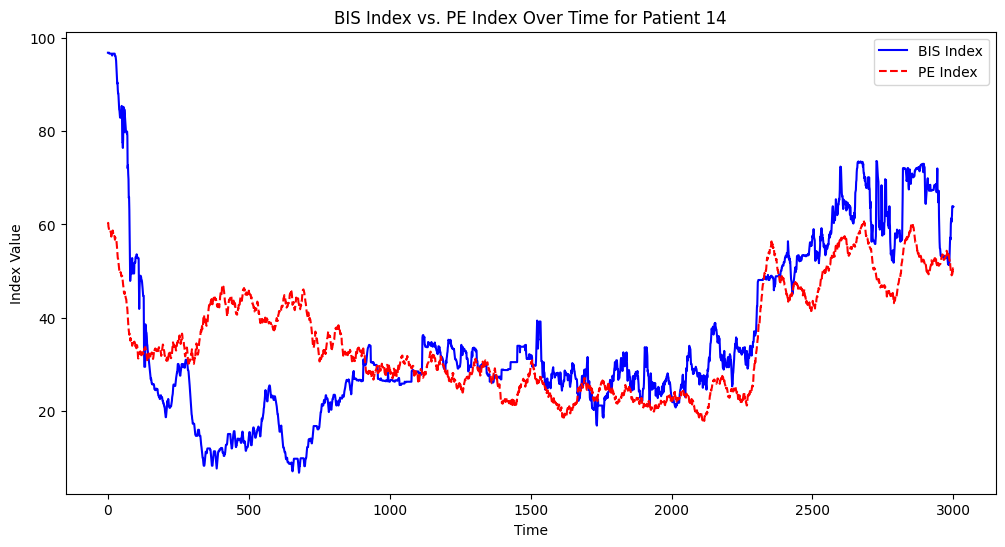

RMSE:  14.45962587858445
(3001,)


In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load BIS data of Patient 14
patient14_bis = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 BIS.txt')

pe_df = pd.DataFrame(pe_values, columns=['PE']) # Convert PE numpy array to pandas DataFrame

# Align BIS and PE values by disregarding the first 55 BIS values, as each PE value will represent the end of the window
bis_aligned = patient14_bis[55:55+len(pe_df)]

# Prepare data
bis_series = pd.Series(bis_aligned, name='BIS')

# Create the PE index
PE1 = pe_df.values.reshape(-1, 1)
PE_model = LinearRegression()
PE_model.fit(PE1, bis_series)
PE_index = PE_model.predict(PE1)

# Calculate the regression coefficients
k_PE = PE_model.coef_[0]
b_PE = PE_model.intercept_
print(f"PE Index Equation: BIS = {k_PE} * PE1 + {b_PE}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(PE_index, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual = np.array([bis_series])
predicted = np.array([PE_index])

mse = mean_squared_error(actual, predicted)

rmse = np.sqrt(mse)

print("RMSE: ", rmse)
print(bis_series.shape)

### Fitness of model - Patient 14 (training data)
The linear regression model created above plots the derived PE index against the BIS index, comparing their performance across the signal duration. Overall, the PE index closely follows BIS, however there is a signficant deviation between 300-700 seconds, during which the PE index was much higher than BIS. Its RMSE value of 14.46, out of index values ranging from 0 to 100, indicates a moderate degree of correlation.

### 2) Test PE linear model using Patient 12 data

PE Index Equation: BIS = 287.03632706217047 * PE2 + -603.4144970953876


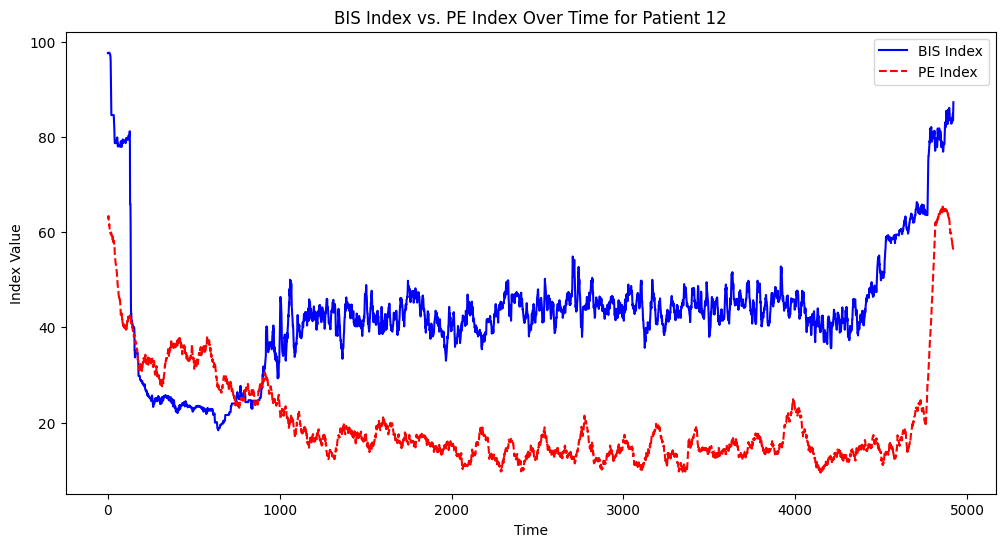

RMSE:  27.252006367354724


In [12]:
# Create moving window for Patient 12
beta_windows_patient12 = moving_window(beta_band_patient12, window_size, step_size, fs)

# Calculate PE values for Patient 12
pe_values_patient12 = []
for window in beta_windows_patient12:
    pe12 = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_patient12.append(pe12)

pe_values_patient12 = np.array(pe_values_patient12)

# Prepare trained model with test data
pe_df_patient12 = pd.DataFrame(pe_values_patient12, columns=['PE'])
X_patient12 = pe_df_patient12[['PE']]

# Align BIS and PE values by disregarding the first 55 BIS values, as each PE value will represent the end of the window
bis_aligned_patient12 = bis_patient12[55:55+len(pe_df_patient12)]

# Create the PE index
PE2 = X_patient12.values.reshape(-1, 1)
# PE_model.fit(PE2, bis_aligned_patient12)
PE_index2 = PE_model.predict(PE2)

# Calculate the regression coefficients
k_PE2 = PE_model.coef_[0]
b_PE2 = PE_model.intercept_
print(f"PE Index Equation: BIS = {k_PE2} * PE2 + {b_PE2}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(PE_index2, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 12')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual_patient12 = np.array([bis_aligned_patient12])
predicted_patient12 = np.array([PE_index2])

mse_patient12 = mean_squared_error(actual_patient12, predicted_patient12)

rmse_patient12 = np.sqrt(mse_patient12)

print("RMSE: ", rmse_patient12)

### Fitness of model - Patient 12 (Testing Data)
The linear regression model trained on Patient 14's data is a poorer predictor of BIS for Patient 12, with a higher RMSE of 27.25. Still, the regression line does follow the general pattern of BIS, dropping and rapidly rising during sharp declines/inclines.

### 3) Create linear regression model for mobility

Mobility Index Equation: BIS = 207.0764915487591 * M1 + -149.97075746583008


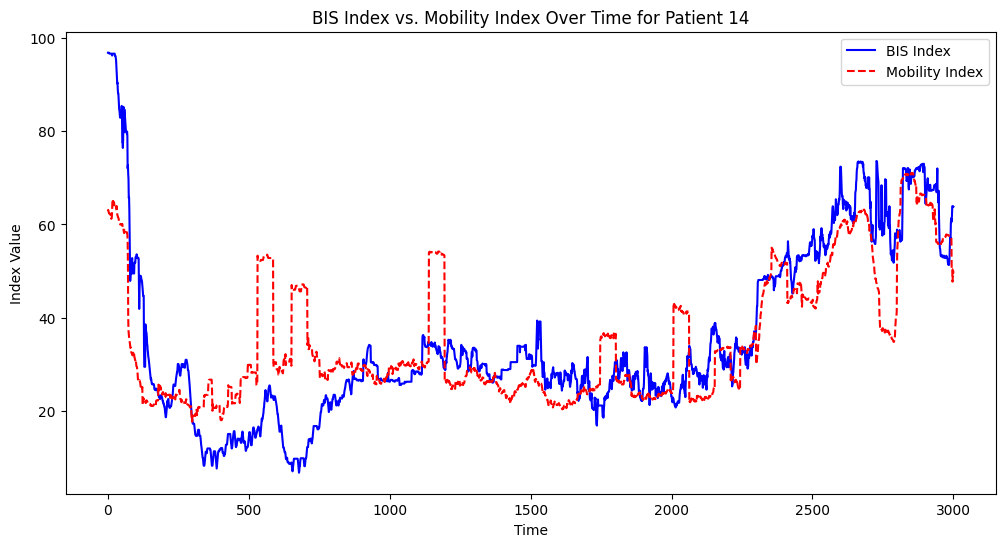

RMSE:  12.028974557200312


In [13]:
mobility_df = pd.DataFrame(mobility_values, columns=['M']) # Convert mobility numpy array to pandas DataFrame

# Create the Mobility index
M1 = mobility_df.values.reshape(-1, 1)
M_model = LinearRegression()
M_model.fit(M1, bis_series)
M_index = M_model.predict(M1)

# Calculate the regression coefficients
k_M = M_model.coef_[0]
b_M = M_model.intercept_
print(f"Mobility Index Equation: BIS = {k_M} * M1 + {b_M}")

# Plot BIS Index vs. Mobility Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(M_index, label='Mobility Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Mobility Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual_mobility = np.array([bis_series])
predicted_mobility = np.array([M_index])

mse_mobility = mean_squared_error(actual_mobility, predicted_mobility)

rmse_mobility = np.sqrt(mse_mobility)

print("RMSE: ", rmse_mobility)

### 4) Test Mobility linear model with Patient 12 data

Mobility Index Equation: BIS = 207.0764915487591 * M1 + -149.97075746583008


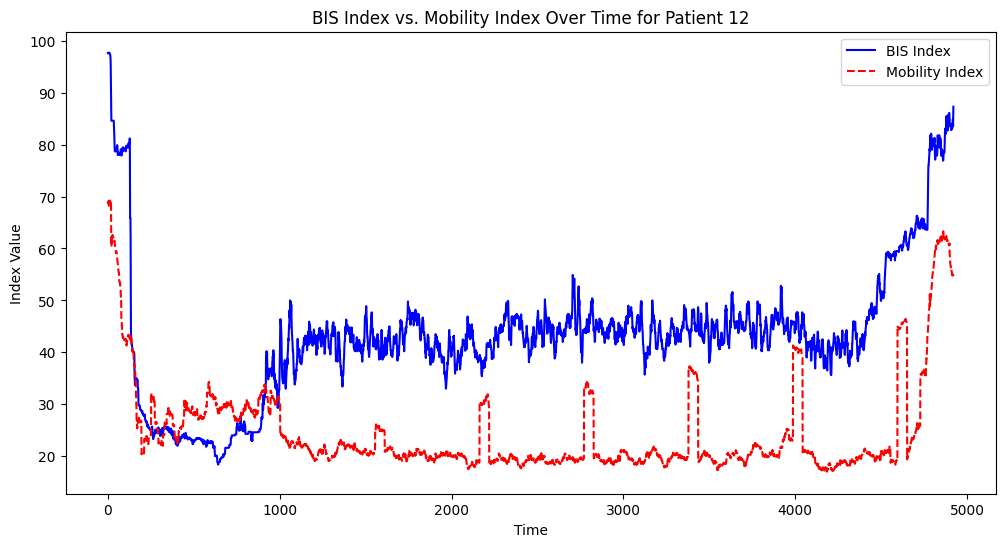

RMSE:  21.78367700575233


In [14]:
mobility_patient12_df = pd.DataFrame(mobility_values_patient12, columns=['M2']) # Convert mobility numpy array to pandas DataFrame

# Create the Mobility index
M2 = mobility_patient12_df.values.reshape(-1, 1)
M_index2 = M_model.predict(M2)

# Calculate the regression coefficients
k_M2 = M_model.coef_[0]
b_M2 = M_model.intercept_
print(f"Mobility Index Equation: BIS = {k_M2} * M1 + {b_M2}")

# Plot BIS Index vs. Mobility Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(M_index2, label='Mobility Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Mobility Index Over Time for Patient 12')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual_mobility_patient12 = np.array([bis_aligned_patient12])
predicted_mobility_patient12 = np.array([M_index2])

mse_mobility_patient12 = mean_squared_error(actual_mobility_patient12, predicted_mobility_patient12)

rmse_mobility_patient12 = np.sqrt(mse_mobility_patient12)

print("RMSE: ", rmse_mobility_patient12)

### 5) Derive new index from mobility and PE

Combined Index Equation: BIS = 12.76 * M1 + 1.51 * PE + 35.22


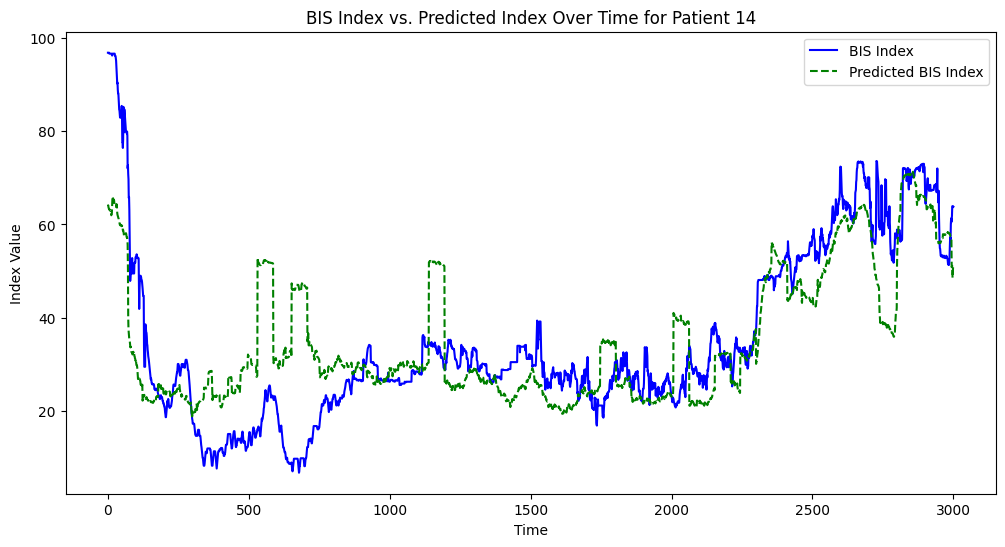

Combined Model RMSE:  11.990845305770769
PE Beta Training Model Pearson CC:  0.7585145252939626


In [40]:
from sklearn.preprocessing import StandardScaler

# Normalise mobility and PE
features = np.column_stack((mobility_values, pe_values))
scaler = StandardScaler()
normalised_features = scaler.fit_transform(features)

M_index_norm = normalised_features[:, 0]
PE_index_norm = normalised_features[:, 1]

X_combined = np.column_stack((M_index_norm, PE_index_norm))
y_combined = bis_series 

# Initialize and fit the linear regression model
combined_model = LinearRegression()
combined_model.fit(X_combined, y_combined)

# Predict the BIS index using the learned model
predicted_bis = combined_model.predict(X_combined)

# Get the regression coefficients and intercept
coefficients = combined_model.coef_
intercept = combined_model.intercept_

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients[0]:.2f} * M1 + {coefficients[1]:.2f} * PE + {intercept:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(predicted_bis, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined = np.sqrt(mean_squared_error(bis_series, predicted_bis))
print("Combined Model RMSE: ", rmse_combined)

# Calculate Pearson correlation coefficient
correlation_combined2_beta, _ = stats.pearsonr(predicted_bis, bis_series)
print("PE Beta Training Model Pearson CC: ", correlation_combined2_beta)

### Fitness of new model
The above graph compares a new combined index with Patient 14's BIS index. Overall, the new index closely follows BIS and its general patterns, but the combined model has a slightly higher RMSE value of 15.23 than the individual features' values (14.46 for PE and 12.03 for mobility).

### 6) Test new combined index with Patient 12 data

Combined Index Equation: BIS = 207.0764915487591 * M1 + -149.97075746583008


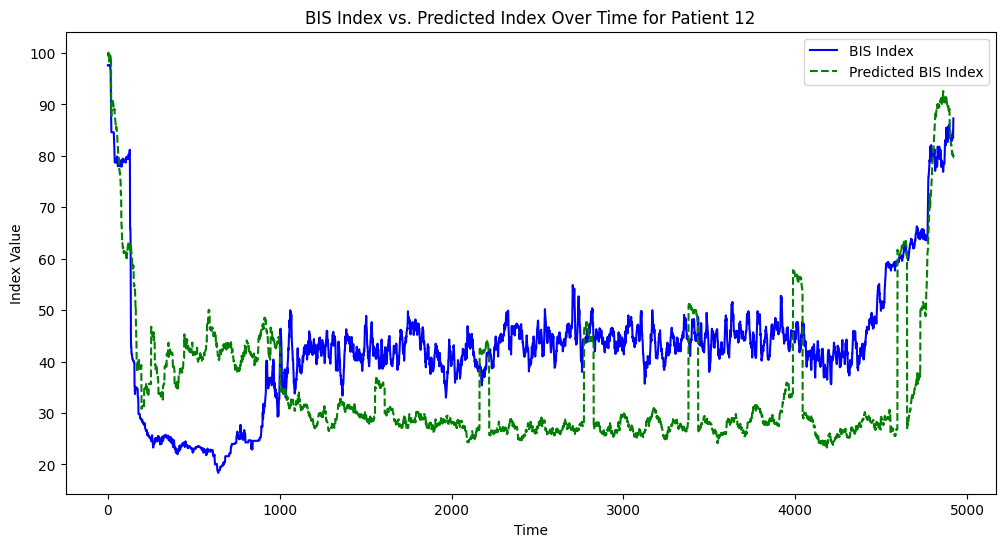

Combined Model RMSE:  15.817616557421719
PE Beta Training Model Pearson CC:  0.4979083127110192


In [42]:
# Normalise mobility and PE for Patient 12
features_patient12 = np.column_stack((mobility_values_patient12, pe_values_patient12))
scaler = StandardScaler()
normalised_features_patient12 = scaler.fit_transform(features_patient12)

M_index_norm_patient12 = normalised_features_patient12[:, 0]
PE_index_norm_patient12 = normalised_features_patient12[:, 1]

X_combined_patient12 = np.column_stack((M_index_norm_patient12, PE_index_norm_patient12))
y_combined_patient12 = bis_aligned_patient12

# Calculate the regression coefficients
k_combined = M_model.coef_[0]
b_combined = M_model.intercept_
print(f"Combined Index Equation: BIS = {k_combined} * M1 + {b_combined}")

# Predict the BIS index using the learned model
predicted_bis_patient12 = combined_model.predict(X_combined_patient12)

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(predicted_bis_patient12, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted Index Over Time for Patient 12')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_patient12 = np.sqrt(mean_squared_error(bis_aligned_patient12, predicted_bis_patient12))
print("Combined Model RMSE: ", rmse_combined_patient12)

# Calculate Pearson correlation coefficient
correlation_combined2_beta_patient12, _ = stats.pearsonr(predicted_bis_patient12, bis_aligned_patient12)
print("PE Beta Training Model Pearson CC: ", correlation_combined2_beta_patient12)

### Summary of model results
| Model            | Training RMSE (Patient 14) | Testing RMSE (Patient 12) |
| :--------------- | :------------------------- | :------------------------ |
| PE               | 14.46                      | 27.25                     |
| Mobility         | 12.02                      | 21.78                     |
| PE and Mobility  | 11.99                      | 15.82                     |
| Sample entropy (SE)| 11.93                    | 10.93                     |
| SE, PE, Mobility | 7.47                       | 11.78                     |               
| Fractal dimension| 14.95                      | 13.32                     |        
| Spectral entropy (SPE) | 14.88                | 23.61                     |       

### 7) Sample entropy feature extraction

In [17]:
se_values2 = []
overall_std = np.std(beta_band)

for i, window in enumerate(beta_windows):
    se2 = ent.sample_entropy(window, 2, 0.2 * overall_std)
    se_values2.append(se2[0])
    print(f"Processed window {i+1}/{len(beta_windows)}")

se_values2 = np.array(se_values2)
np.save('se_values2.npy', se_values2)
print(se_values2.shape)

Processed window 1/3001
Processed window 2/3001
Processed window 3/3001
Processed window 4/3001
Processed window 5/3001
Processed window 6/3001
Processed window 7/3001
Processed window 8/3001
Processed window 9/3001
Processed window 10/3001
Processed window 11/3001
Processed window 12/3001
Processed window 13/3001
Processed window 14/3001
Processed window 15/3001
Processed window 16/3001
Processed window 17/3001
Processed window 18/3001
Processed window 19/3001
Processed window 20/3001
Processed window 21/3001
Processed window 22/3001
Processed window 23/3001
Processed window 24/3001
Processed window 25/3001
Processed window 26/3001
Processed window 27/3001
Processed window 28/3001
Processed window 29/3001
Processed window 30/3001
Processed window 31/3001
Processed window 32/3001
Processed window 33/3001
Processed window 34/3001
Processed window 35/3001
Processed window 36/3001
Processed window 37/3001
Processed window 38/3001
Processed window 39/3001
Processed window 40/3001
Processed

SE Index Equation: BIS = 44.35637871352023 * SE1 + -19.45528840469965


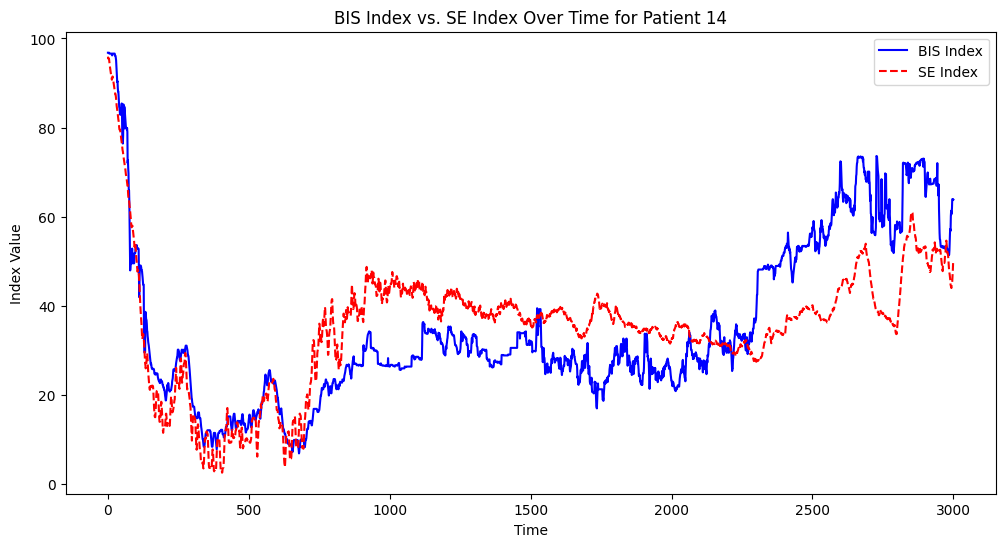

SE Beta Training Model RMSE:  11.936246307788968
SE Beta Training Model Pearson CC:  0.761053695159619


In [32]:
from scipy import stats

# Create the SE index
se_df = pd.DataFrame(se_values2, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE1 = se_df.values.reshape(-1, 1)
SE_model = LinearRegression()
SE_model.fit(SE1, bis_series)
SE_index = SE_model.predict(SE1)

# Calculate the regression coefficients
k_SE = SE_model.coef_[0]
b_SE = SE_model.intercept_
print(f"SE Index Equation: BIS = {k_SE} * SE1 + {b_SE}")

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SE_index, label='SE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_beta = np.sqrt(mean_squared_error(SE_index, bis_series))
print("SE Beta Training Model RMSE: ", rmse_se_beta)

# Calculate Pearson correlation coefficient
correlation_se_beta, _ = stats.pearsonr(SE_index, bis_series)
print("SE Beta Training Model Pearson CC: ", correlation_se_beta)

### 8) Testing SE index on Patient 12

In [19]:
se_values_patient12 = []
overall_std_patient12 = np.std(beta_band_patient12)
for i, window in enumerate(beta_windows_patient12):
    se_patient12 = ent.sample_entropy(window, 2, 0.2 * overall_std_patient12)
    se_values_patient12.append(se_patient12[0])
    print(f"Processed window {i+1}/{len(beta_windows_patient12)}")

se_values_patient12 = np.array(se_values_patient12)
np.save('se_values_patient12.npy', se_values_patient12)
print(se_values_patient12.shape)

Processed window 1/4921
Processed window 2/4921
Processed window 3/4921
Processed window 4/4921
Processed window 5/4921
Processed window 6/4921
Processed window 7/4921
Processed window 8/4921
Processed window 9/4921
Processed window 10/4921
Processed window 11/4921
Processed window 12/4921
Processed window 13/4921
Processed window 14/4921
Processed window 15/4921
Processed window 16/4921
Processed window 17/4921
Processed window 18/4921
Processed window 19/4921
Processed window 20/4921
Processed window 21/4921
Processed window 22/4921
Processed window 23/4921
Processed window 24/4921
Processed window 25/4921
Processed window 26/4921
Processed window 27/4921
Processed window 28/4921
Processed window 29/4921
Processed window 30/4921
Processed window 31/4921
Processed window 32/4921
Processed window 33/4921
Processed window 34/4921
Processed window 35/4921
Processed window 36/4921
Processed window 37/4921
Processed window 38/4921
Processed window 39/4921
Processed window 40/4921
Processed

SE Index Equation: BIS = 44.35637871352023 * SE1 + -19.45528840469965


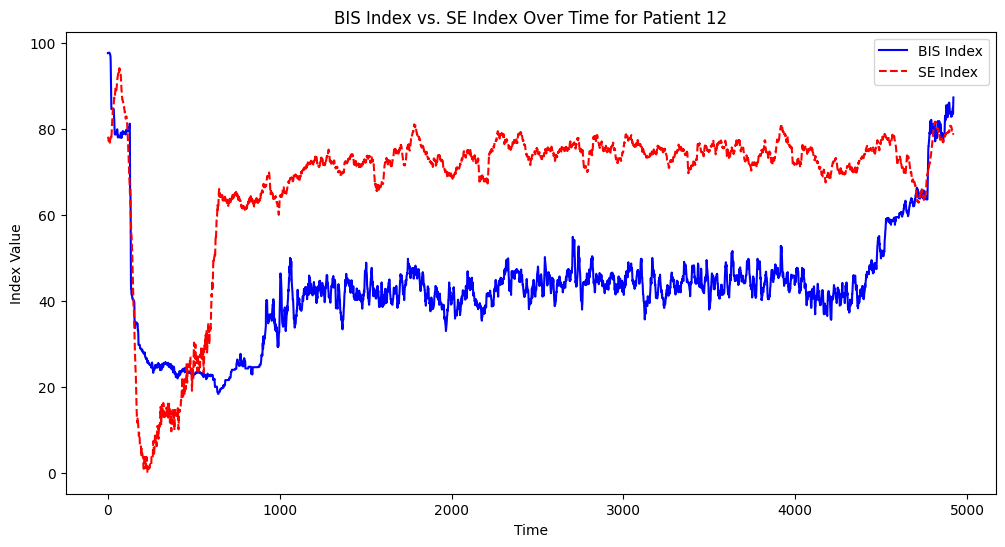

SE Beta Training Model RMSE:  28.336523195024633
SE Beta Training Model Pearson CC:  0.5698623143548859


In [33]:
# Create the SE index for testing
se_df2 = pd.DataFrame(se_values_patient12, columns=['SE2']) # Convert SE numpy array to pandas DataFrame
SE2  = se_df2.values.reshape(-1, 1)
SE_index2 = SE_model.predict(SE2)

# Calculate the regression coefficients
k_SE2 = SE_model.coef_[0]
b_SE2 = SE_model.intercept_
print(f"SE Index Equation: BIS = {k_SE2} * SE1 + {b_SE2}")

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SE_index2, label='SE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index Over Time for Patient 12')
plt.legend()
plt.show()


# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_beta_patient12 = np.sqrt(mean_squared_error(SE_index2, bis_aligned_patient12))
print("SE Beta Training Model RMSE: ", rmse_se_beta_patient12)

# Calculate Pearson correlation coefficient
correlation_se_beta_patient12, _ = stats.pearsonr(SE_index2, bis_aligned_patient12)
print("SE Beta Training Model Pearson CC: ", correlation_se_beta_patient12)

### 9) Training a three-feature model

Combined Index (3 features) Equation: BIS = 2.11 * M1 + 7.86 * PE + 11.71 * SE + 35.22


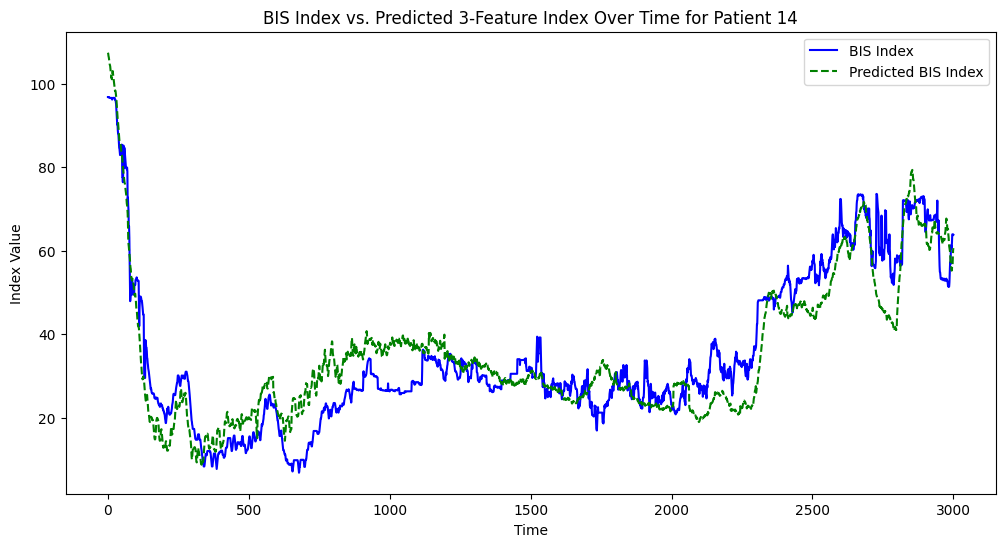

Combined Model (3 features) RMSE:  7.469705466909294
SE Beta Training Model Pearson CC:  0.9138954464795922


In [35]:
# Create new index based on 3 features: mobility, PE, and SE, and train it on Patient 14

# Normalise mobility, PE, and SE
features3 = np.column_stack((mobility_values, pe_values, se_values2))
scaler = StandardScaler()
normalised_features3 = scaler.fit_transform(features3)

M_index_norm3 = normalised_features3[:, 0]
PE_index_norm3 = normalised_features3[:, 1]
SE_index_norm3 = normalised_features3[:, 2]

X_combined3 = np.column_stack((M_index_norm3, PE_index_norm3, SE_index_norm3))
y_combined3 = bis_series 

# Initialize and fit the linear regression model
combined_model3 = LinearRegression()
combined_model3.fit(X_combined3, y_combined3)

# Predict the BIS index using the learned model
predicted_bis3 = combined_model3.predict(X_combined3)

# Get the regression coefficients and intercept
coefficients3 = combined_model3.coef_
intercept3 = combined_model3.intercept_

# Output the combined index equation
print(f"Combined Index (3 features) Equation: BIS = {coefficients3[0]:.2f} * M1 + {coefficients3[1]:.2f} * PE + {coefficients3[2]:.2f} * SE + {intercept3:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(predicted_bis3, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted 3-Feature Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined3 = np.sqrt(mean_squared_error(bis_series, predicted_bis3))
print("Combined Model (3 features) RMSE: ", rmse_combined3)

# Calculate Pearson correlation coefficient
correlation_combined3_beta, _ = stats.pearsonr(predicted_bis3, bis_series)
print("SE Beta Training Model Pearson CC: ", correlation_combined3_beta)

### 10) Testing the three-feature model on Patient 12

Combined Index (3 features) Equation: BIS = 2.11 * M1 + 7.86 * PE + 11.71 * SE + 35.22


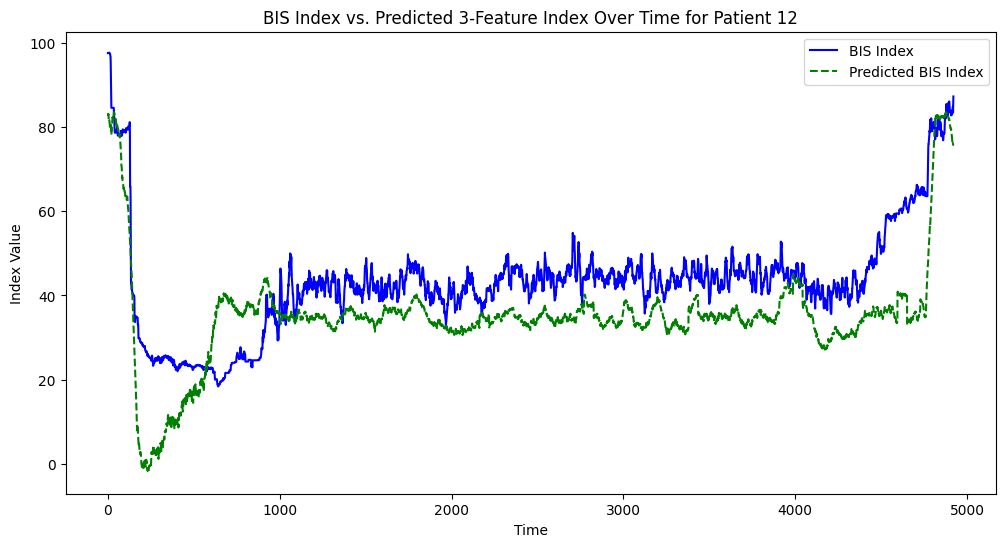

Combined Model (3 features) RMSE:  11.783051285095288
SE Beta Training Model Pearson CC:  0.7797109435727223


In [36]:
# Create new index based on 3 features: mobility, PE, and SE, and test it on Patient 12

# Normalise mobility, PE, and SE
features3_patient12 = np.column_stack((mobility_values_patient12, pe_values_patient12, se_values_patient12))
scaler = StandardScaler()
normalised_features3_patient12 = scaler.fit_transform(features3_patient12)

M_index_norm3_patient12 = normalised_features3_patient12[:, 0]
PE_index_norm3_patient12 = normalised_features3_patient12[:, 1]
SE_index_norm3_patient12 = normalised_features3_patient12[:, 2]

X_combined3_patient12 = np.column_stack((M_index_norm3_patient12, PE_index_norm3_patient12, SE_index_norm3_patient12))
y_combined3_patient12 = bis_series 

# Predict the BIS index using the learned model
predicted_bis3_patient12 = combined_model3.predict(X_combined3_patient12)

# Output the combined index equation
print(f"Combined Index (3 features) Equation: BIS = {coefficients3[0]:.2f} * M1 + {coefficients3[1]:.2f} * PE + {coefficients3[2]:.2f} * SE + {intercept3:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(predicted_bis3_patient12, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted 3-Feature Index Over Time for Patient 12')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined3_patient12 = np.sqrt(mean_squared_error(bis_aligned_patient12, predicted_bis3_patient12))
print("Combined Model (3 features) RMSE: ", rmse_combined3_patient12)

# Calculate Pearson correlation coefficient
correlation_combined3_beta_patient12, _ = stats.pearsonr(predicted_bis3_patient12, bis_aligned_patient12)
print("SE Beta Training Model Pearson CC: ", correlation_combined3_beta_patient12)

### 11) Creating a new index based on fractal dimension (FD)

In [23]:
import antropy as ant

fd_values = []

for i, window in enumerate(beta_windows):
    fd = ant.higuchi_fd(window)
    fd_values.append(fd)

fd_values = np.array(fd_values)
print(fd_values.shape)

(3001,)


FD Index Equation: BIS = 959.4142652100251 * FE1 + -1855.1058617249985


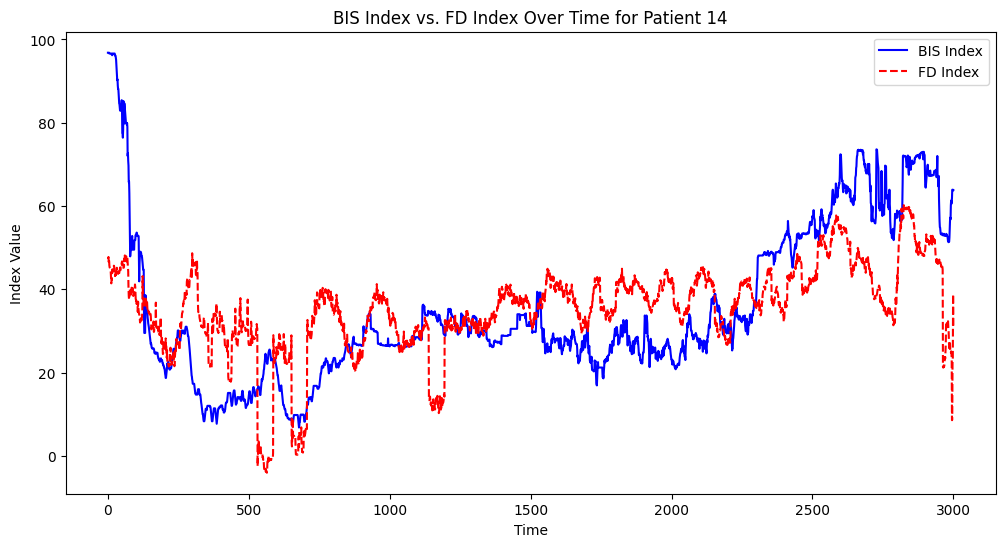

RMSE:  14.951895199462513
(3001,)


In [24]:
# Create the FD index
fd_df = pd.DataFrame(fd_values, columns=['FD']) # Convert FD numpy array to pandas DataFrame
FD1 = fd_df.values.reshape(-1, 1)
FD_model = LinearRegression()
FD_model.fit(FD1, bis_series)
FD_index = FD_model.predict(FD1)

# Calculate the regression coefficients
k_FD = FD_model.coef_[0]
b_FD = FD_model.intercept_
print(f"FD Index Equation: BIS = {k_FD} * FE1 + {b_FD}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual_FD = np.array([bis_series])
predicted_FD = np.array([FD_index])

mse_FD = mean_squared_error(actual_FD, predicted_FD)

rmse_FD = np.sqrt(mse_FD)

print("RMSE: ", rmse_FD)
print(bis_series.shape)

In [25]:
fd_values2 = []

for i, window in enumerate(beta_windows_patient12):
    fd2 = ant.higuchi_fd(window)
    fd_values2.append(fd2)

fd_values2 = np.array(fd_values2)
print(fd_values2.shape)

(4921,)


FD Index Equation: BIS = 959.4142652100251 * SE1 + -1855.1058617249985


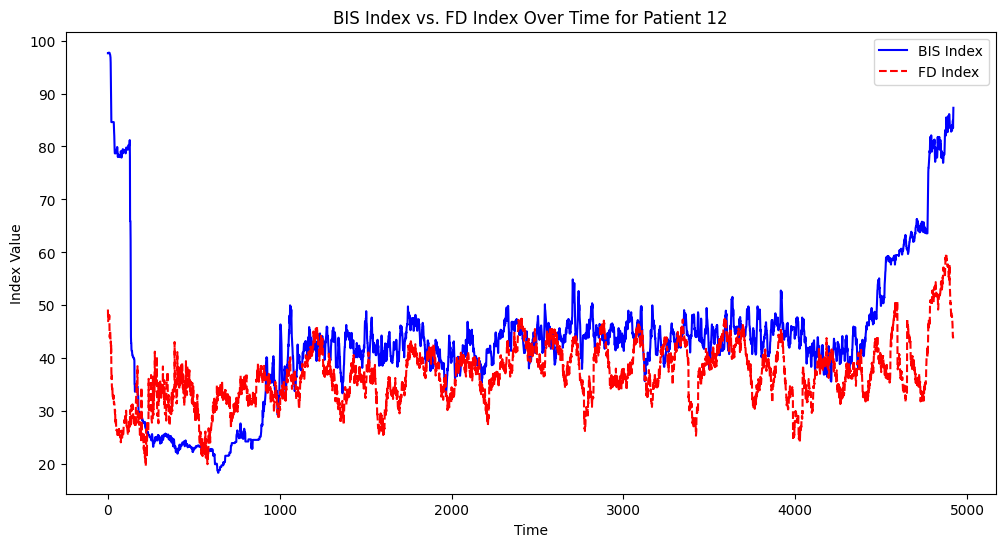

RMSE:  13.316161177260915
SE Beta Training Model Pearson CC:  0.4330638241203164


In [39]:
# Create the FD index for testing
fd_df2 = pd.DataFrame(fd_values2, columns=['FD2']) # Convert SE numpy array to pandas DataFrame
FD2 = fd_df2.values.reshape(-1, 1)
FD_index2 = FD_model.predict(FD2)

# Calculate the regression coefficients
k_FD2 = FD_model.coef_[0]
b_FD2 = FD_model.intercept_
print(f"FD Index Equation: BIS = {k_FD2} * SE1 + {b_FD2}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(FD_index2, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 12')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual_FD2 = np.array([bis_aligned_patient12])
predicted_FD2 = np.array([FD_index2])

mse_FD2 = mean_squared_error(actual_FD2, predicted_FD2)

rmse_FD2 = np.sqrt(mse_FD2)

print("RMSE: ", rmse_FD2)

# Calculate Pearson correlation coefficient
correlation_fd_beta_patient12, _ = stats.pearsonr(FD_index2, bis_aligned_patient12)
print("SE Beta Training Model Pearson CC: ", correlation_fd_beta_patient12)

## 12) Spectral Entropy

In [27]:
spe_values = []

for i, window in enumerate(beta_windows):
    spe = ant.spectral_entropy(window, sf=128)
    spe_values.append(spe)

spe_values = np.array(spe_values)
print(spe_values.shape)

(3001,)


SPE Index Equation: BIS = 46.32167523818388 * SPE1 + -384.12964722091664


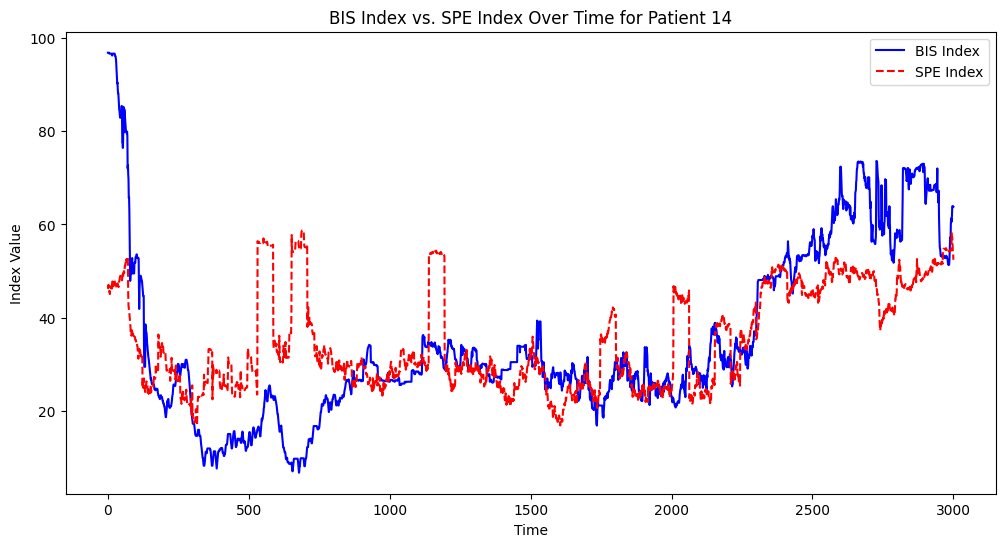

RMSE:  14.881479806038351
SE Beta Training Model Pearson CC:  0.5881512519004074


In [37]:
# Create the SPE (Spectral Entropy) index
spe_df = pd.DataFrame(spe_values, columns=['SPE']) # Convert SPE numpy array to pandas DataFrame
SPE1 = spe_df.values.reshape(-1, 1)
SPE_model = LinearRegression()
SPE_model.fit(SPE1, bis_series)
SPE_index = SPE_model.predict(SPE1)

# Calculate the regression coefficients
k_SPE = SPE_model.coef_[0]
b_SPE = SPE_model.intercept_
print(f"SPE Index Equation: BIS = {k_SPE} * SPE1 + {b_SPE}")

# Plot BIS Index vs. SPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SPE_index, label='SPE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SPE Index Over Time for Patient 14')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_SPE = np.sqrt(mean_squared_error(bis_series, SPE_index))
print("RMSE: ", rmse_SPE)

# Calculate Pearson correlation coefficient
correlation_spe_beta, _ = stats.pearsonr(SPE_index, bis_series)
print("SE Beta Training Model Pearson CC: ", correlation_spe_beta)

In [29]:
spe_values2 = []

for i, window in enumerate(beta_windows_patient12):
    spe2 = ant.spectral_entropy(window, sf=128)
    spe_values2.append(spe2)

spe_values2 = np.array(spe_values2)
print(spe_values2.shape)

(4921,)


SPE Index Equation: BIS = 46.32167523818388 * SPE1 + -384.12964722091664


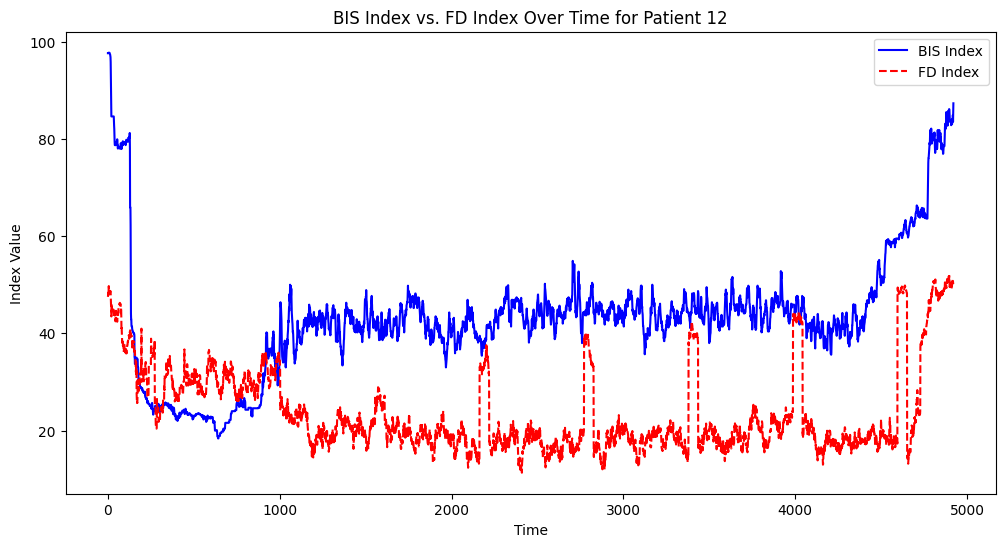

RMSE:  23.61010583536935
SE Beta Training Model Pearson CC:  0.2968672885157952


In [38]:
# Create the SPE index for testing
spe_df2 = pd.DataFrame(spe_values2, columns=['SPE2']) # Convert SE numpy array to pandas DataFrame
SPE2 = spe_df2.values.reshape(-1, 1)
SPE_index2 = SPE_model.predict(SPE2)

# Print regression equation
print(f"SPE Index Equation: BIS = {k_SPE} * SPE1 + {b_SPE}")

# Plot BIS Index vs. SPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SPE_index2, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 12')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_SPE2 = np.sqrt(mean_squared_error(bis_aligned_patient12, SPE_index2))
print("RMSE: ", rmse_SPE2)

# Calculate Pearson correlation coefficient
correlation_spe_beta_patient12, _ = stats.pearsonr(SPE_index2, bis_aligned_patient12)
print("SE Beta Training Model Pearson CC: ", correlation_spe_beta_patient12)